In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import multiprocessing as mp
from tqdm import tqdm

import json
import matplotlib.pyplot as plt

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carga de datos

In [2]:
train_data = pd.read_csv("data/train.csv")
metadata = pd.read_csv("data/supplemental_metadata.csv")
char_to_pred = json.load(open("data/character_to_prediction_index.json", "r"))

In [3]:
train_data.head()

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


# Analisis Exploratorio

In [4]:
print("--------------------Train data--------------------")
print(f"Cantidad de filas : {train_data.shape[0]}")
print(f"Cantidad de participantes : {train_data.participant_id.nunique()}")
print(f"Cantidad de frases unicas : {train_data.phrase.nunique()}")

--------------------Train data--------------------
Cantidad de filas : 67208
Cantidad de participantes : 94
Cantidad de frases unicas : 46478


In [5]:
print("--------------------Metadata--------------------")
print(f"Cantidad de filas : {metadata.shape[0]}")
print(f"Cantidad de participantes : {metadata.participant_id.nunique()}")
print(f"Cantidad de frases unicas : {metadata.phrase.nunique()}")

--------------------Metadata--------------------
Cantidad de filas : 52958
Cantidad de participantes : 72
Cantidad de frases unicas : 508


In [6]:
train_data.describe()

,file_id,sequence_id,participant_id
count,6.720800e+04,6.720800e+04,67208.000000
mean,1.094448e+09,1.072696e+09,119.758154
std,6.395616e+08,6.177372e+08,74.330468
min,5.414471e+06,7.109500e+04,0.000000
25%,5.277082e+08,5.376519e+08,63.000000
50%,1.099408e+09,1.074387e+09,113.000000
75%,1.662743e+09,1.605592e+09,178.000000
max,2.118949e+09,2.147465e+09,254.000000


# Levenshtein Distance
* Ref: https://blog.paperspace.com/implementing-levenshtein-distance-word-autocomplete-autocorrect/#:~:text=The%20Levenshtein%20distance%20is%20a,transform%20one%20word%20into%20another.

In [7]:
def printDistances(distances, token1Length, token2Length):
    for t1 in range(token1Length + 1):
        for t2 in range(token2Length + 1):
            print(int(distances[t1][t2]), end=" ")
        print()

def levenshteinDistanceDP(token1, token2):
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    printDistances(distances, len(token1), len(token2))
    return distances[len(token1)][len(token2)]

In [8]:
# levenshteinDistanceDP("kelm", "hello")

# Preprocesamiento del Modelo

Solo se obtienen 20 indices de las coordenadas x y y, ya que son las unicas que han sido altamente entrenadas del modelo mediapipe de Google

In [9]:
def get_needed_cols():
    cols = []

    for i in range(20):
        cols.append(f'x_right_hand_{i}')
        cols.append(f'y_right_hand_{i}')
        cols.append(f'x_left_hand_{i}')
        cols.append(f'y_left_hand_{i}')
    
    return cols

In [10]:
selected_columns = get_needed_cols()
sample = pd.read_parquet("data/train_landmarks/1019715464.parquet", columns=selected_columns)

In [11]:
sample.head()

,x_right_hand_0,y_right_hand_0,x_left_hand_0,y_left_hand_0,x_right_hand_1,y_right_hand_1,x_left_hand_1,y_left_hand_1,x_right_hand_2,y_right_hand_2,...,x_left_hand_17,y_left_hand_17,x_right_hand_18,y_right_hand_18,x_left_hand_18,y_left_hand_18,x_right_hand_19,y_right_hand_19,x_left_hand_19,y_left_hand_19
sequence_id,,,,,,,,,,,,,,,,,,,,,
1975433633,0.223376,0.755344,NaN,NaN,0.314379,0.755479,NaN,NaN,0.381249,0.726833,...,NaN,NaN,0.105947,0.612873,NaN,NaN,0.093977,0.584119,NaN,NaN
1975433633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1975433633,0.229610,0.763030,NaN,NaN,0.323558,0.757111,NaN,NaN,0.391224,0.726754,...,NaN,NaN,0.107829,0.601616,NaN,NaN,0.098407,0.567502,NaN,NaN
1975433633,0.233477,0.764909,NaN,NaN,0.324557,0.758571,NaN,NaN,0.396712,0.725978,...,NaN,NaN,0.112081,0.599290,NaN,NaN,0.102222,0.565760,NaN,NaN
1975433633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Modelo

In [12]:
s = pd.read_parquet('./data/train_landmarks/1019715464.parquet', columns=selected_columns)
s.index.unique()


Int64Index([1975433633, 1975473601, 1975502450, 1975521182, 1975541698,
            1975562925, 1975572309, 1975589819, 1975645112, 1975681715,
            ...
            2008298404, 2008390516, 2008391544, 2008398258, 2008458433,
            2008510769, 2008527389, 2008541811, 2008579279, 2008677531],
           dtype='int64', name='sequence_id', length=998)

In [13]:
len(s)

161461

In [14]:
s = s.reset_index().rename(columns={'index': 'sequence_id'})

In [15]:
# # Select 200 random samples from the index column
# sampled_index = s['sequence_id'].sample(n=300).unique()
# s = s.loc[s['sequence_id'].isin(sampled_index)]

In [16]:
phrases = pd.read_csv("data/train.csv", usecols=["sequence_id", "phrase"])

In [17]:
phrases.columns

Index(['sequence_id', 'phrase'], dtype='object')

In [18]:
len(phrases)

67208

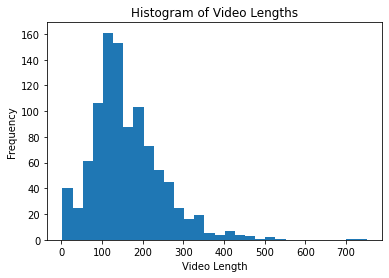

In [19]:
merged = pd.merge(s, phrases, on='sequence_id')
# Compute the lengths of the video sequences
video_lengths = merged.groupby('sequence_id').size()

# Plot the histogram
plt.hist(video_lengths, bins=30)  # Adjust the number of bins as needed
plt.xlabel('Video Length')
plt.ylabel('Frequency')
plt.title('Histogram of Video Lengths')
plt.show()

In [20]:
# Determine the maximum sequence length
grouped = merged.groupby('sequence_id')

max_seq_length = 170

# Filter out IDs with more than 170 rows
filtered_df = grouped.filter(lambda x: len(x) <= max_seq_length)
# filtered_df['phrase'].unique()

In [21]:
# Create a new DataFrame to store the filled rows
filled_df = pd.DataFrame()
target = []


# Iterate over each group and fill remaining rows with zero
for _, group in filtered_df.groupby('sequence_id'):
    remaining_rows = max_seq_length - len(group)
    if remaining_rows > 0:
        zeros_df = pd.DataFrame([[0] * len(group.columns)] * remaining_rows, columns=group.columns)
        zeros_df['sequence_id'] = group['sequence_id'].unique()[0]
        zeros_df['phrase'] = group['phrase'].unique()[0]
        group = pd.concat([group, zeros_df])
    
    if (group["phrase"].unique()[0] not in target):
        filled_df = filled_df.append(group)
        target.append(group["phrase"].unique()[0])
    
filled_df.reset_index(drop=True, inplace=True)

In [22]:
len(target)

607

In [23]:
set(filled_df.groupby('sequence_id').size().to_list())

{170}

In [24]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [25]:
del filled_df["sequence_id"] 
del filled_df["phrase"] 

In [26]:
y = target #La variable respuesta
X = filled_df.fillna(0) #El resto de los datos

In [27]:
num_timesteps = max_seq_length
num_features = len(get_needed_cols())
num_classes = len(y)

In [28]:
expected_size =  num_classes * num_timesteps * num_features
actual_size = X.iloc[:, :num_features].values.size
if expected_size != actual_size:
    raise ValueError("The total number of elements in the DataFrame does not match the expected size.")

In [29]:
X = X.values.reshape(num_classes, num_timesteps, num_features)

In [30]:
X.shape

(607, 170, 80)

In [31]:
# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.30, random_state=42)

In [33]:
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (424, 170, 80) (424, 607)
Test: (183, 170, 80) (183, 607)


In [34]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(num_timesteps, num_features)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [35]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [36]:
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
14/14 - 5s - loss: 6.4119 - accuracy: 0.0000e+00 - 5s/epoch - 355ms/step
Epoch 2/10
14/14 - 2s - loss: 6.3932 - accuracy: 0.0024 - 2s/epoch - 160ms/step
Epoch 3/10
14/14 - 2s - loss: 6.3449 - accuracy: 0.0024 - 2s/epoch - 163ms/step
Epoch 4/10
14/14 - 2s - loss: 6.2646 - accuracy: 0.0047 - 2s/epoch - 163ms/step
Epoch 5/10
14/14 - 2s - loss: 6.1182 - accuracy: 0.0024 - 2s/epoch - 159ms/step
Epoch 6/10
14/14 - 2s - loss: 6.0161 - accuracy: 0.0024 - 2s/epoch - 161ms/step
Epoch 7/10
14/14 - 2s - loss: 5.9004 - accuracy: 0.0094 - 2s/epoch - 165ms/step
Epoch 8/10
14/14 - 2s - loss: 5.7585 - accuracy: 0.0024 - 2s/epoch - 164ms/step
Epoch 9/10
14/14 - 2s - loss: 5.6725 - accuracy: 0.0094 - 2s/epoch - 163ms/step
Epoch 10/10
14/14 - 2s - loss: 5.5814 - accuracy: 0.0071 - 2s/epoch - 160ms/step
